# Data Jobs  
## Preface  
I aimed to make an analysis and a visualization of some data related to jobs in Data Science.  
Some things are definitely of my personal interest, and you, a fellow student who will check this work, are involved.  
Possible candidates would be how long it takes to find jobs (how many applications, for example), the number of job postings vs resumes, etc.  
Surprisingly, it was extremely hard to find data on this.  
There are some articles out there that state how everything is complicated in the Industry right now, they have aggregated numbers sometimes.  
But raw data... I have spent around 6 hours finding something really useful.  
Hopefully it's worth it!  

This is a part of educational process, and important pat of teask is to collect how other people see the graphics.  
So, there is some duplicates in data representation.  

## The Data  
The data is taken from [public repository](https://huggingface.co/datasets/lukebarousse/data_jobs) on Higgingface: https://huggingface.co/datasets/lukebarousse/data_jobs  
It is a big dataset with 785,741 rows and rather a lot of columns, so I will start with preprocessing data and defining the subset for analysis.  
All the data is from 2023.  


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import altair as alt
from wordcloud import WordCloud
import matplotlib.pyplot as plt

try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
except:
    pass # local version

## Preprocessing - subset selection  
We can omit some of the data to make analysis more straightforward:  
job_location & search_location are not necessary since we will analyse by job_country  
company_name is out of interest, as well as job_health_insurance and job_via   
job_titled is aggregate in job_title_short  
job_posted_date is out of skope of this analysis  


In [2]:
try:
    df = pd.read_csv('data_jobs.csv') # locally downloaded dataset from the hugging face, due to its size (>200MB) this is optimal way
except:
    file_path = 'data_jobs.csv'
    df = kagglehub.load_dataset(
      KaggleDatasetAdapter.PANDAS,
      "wandererfakeer/data-jobs-by-lukebarousse",
      file_path,
    )

df.shape

(785741, 17)

In [3]:
print(df.duplicated().sum())

# full duplicates we can drop
df = df.drop_duplicates()

101


In [4]:
# Dropping some columns
display(df.head(1))
print(df.dtypes)

columns_to_omit = ["company_name", "job_title"
                   , "job_location", "search_location"
                   , "job_health_insurance"
                   , "job_posted_date"
                   , "job_via"]
all_columns = df.columns.tolist()
df = df.drop(columns=columns_to_omit)


,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,NaN,NaN,NaN,Boehringer Ingelheim,NaN,NaN


job_title_short           object
job_title                 object
job_location              object
job_via                   object
job_schedule_type         object
job_work_from_home          bool
search_location           object
job_posted_date           object
job_no_degree_mention       bool
job_health_insurance        bool
job_country               object
salary_rate               object
salary_year_avg          float64
salary_hour_avg          float64
company_name              object
job_skills                object
job_type_skills           object
dtype: object


In [5]:
df.head(1)

,job_title_short,job_schedule_type,job_work_from_home,job_no_degree_mention,job_country,salary_rate,salary_year_avg,salary_hour_avg,job_skills,job_type_skills
0,Senior Data Engineer,Full-time,False,False,United States,NaN,NaN,NaN,NaN,NaN


In [6]:
df['job_country'].value_counts()

countries_big = df['job_country'].value_counts().index[:40].tolist()
df['job_country'] = df['job_country'].apply(lambda x: x if x in countries_big else 'Other')
# there are 150 countries and graphs become really messy if we include all of them  

In [7]:
print(f"Unique values for job title short: {df['job_title_short'].nunique()}")
display(df['job_title_short'].value_counts())

# we can remove Senior + space from the job title
df['job_title_short'] = df['job_title_short'].str.replace('Senior ', '')

Unique values for job title short: 10


job_title_short
Data Analyst                 196050
Data Engineer                186216
Data Scientist               172263
Business Analyst              49053
Software Engineer             44918
Senior Data Engineer          44561
Senior Data Scientist         36955
Senior Data Analyst           29214
Machine Learning Engineer     14079
Cloud Engineer                12331
Name: count, dtype: int64

In [8]:
df['job_schedule_type'].value_counts()
# Of main interested is full-time and this is the biggest subset, so we can keep only Full-time and drop the rest and the column itself
df = df[df['job_schedule_type'] == 'Full-time']
df = df.drop(columns=['job_schedule_type'])

In [9]:
display(df['job_work_from_home'].value_counts())
display(df['job_no_degree_mention'].value_counts())

# number fo nans
print(df.isna().sum())

# additionally we can drop columns with salary information as they have a lot of nans
df = df.drop(columns=['salary_rate', 'salary_year_avg', 'salary_hour_avg'])  

# and rows with nans in job_skills and job_type_skills, job_country, as this is of interest and relatevly smaller subset  
df = df.dropna(subset=['job_skills', 'job_type_skills', 'job_country'])

job_work_from_home
False    645663
True      55975
Name: count, dtype: int64

job_no_degree_mention
False    487352
True     214286
Name: count, dtype: int64

job_title_short               0
job_work_from_home            0
job_no_degree_mention         0
job_country                   0
salary_rate              676137
salary_year_avg          680621
salary_hour_avg          697520
job_skills               103916
job_type_skills          103916
dtype: int64


In [10]:
print(df.shape)
display(df.head(10))

(597722, 6)


,job_title_short,job_work_from_home,job_no_degree_mention,job_country,job_skills,job_type_skills
1,Data Analyst,False,False,Mexico,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr..."
2,Data Engineer,False,False,Germany,"['python', 'sql', 'c#', 'azure', 'airflow', 'd...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."
3,Data Engineer,False,True,United States,"['python', 'c++', 'java', 'matlab', 'aws', 'te...","{'cloud': ['aws'], 'libraries': ['tensorflow',..."
4,Data Engineer,False,False,Sudan,"['bash', 'python', 'oracle', 'aws', 'ansible',...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl..."
6,Data Engineer,False,False,United States,"['sql', 'python', 'java', 'sql server', 'gcp',...","{'cloud': ['gcp', 'bigquery'], 'databases': ['..."
7,Data Engineer,True,False,Romania,"['sql', 'nosql', 'gcp', 'azure', 'aws', 'bigqu...","{'cloud': ['gcp', 'azure', 'aws', 'bigquery', ..."
8,Business Analyst,False,False,Denmark,"['excel', 'powerpoint', 'power bi']","{'analyst_tools': ['excel', 'powerpoint', 'pow..."
9,Data Scientist,True,False,United States,"['sql', 'python', 'r', 'mongodb', 'mongodb', '...","{'analyst_tools': ['excel'], 'cloud': ['azure'..."
10,Data Engineer,False,True,Switzerland,"['python', 'databricks', 'azure', 'spark']","{'cloud': ['databricks', 'azure'], 'libraries'..."
11,Data Engineer,False,False,United States,"['python', 'qlik']","{'analyst_tools': ['qlik'], 'programming': ['p..."


### Data Preprocessign result  
We have shrinked our dataset to keep information on location (country), job title, degree requirements and work from home condition, as well as job skills.  
Without missing values and still with tremendous aprox 600,000 rows.  


## Goals for Analysis and visualization  
Visualization and analysis are separated onto three groups.  
At first, it is interesting to analyse number of jobs by title, it's correlation with work from home and degree requirements.  
Second, correlation of this factors with geography can be considered.  
Thirdly, analysis of the skills will be performed.

### Task  
**The task is to gain insight into the job market for Data-related specializations.**  
**Goal**: To know if the higher education is really important for data science, to better understand job market trends, as well is know about the important skills  
**Means**: Visually analyse the dataset of recent job postings, especially relation on different job titles.  
**Characteristics**: Trends, dependencies, correlation, max values  
**Target data**: Subset as described before - containing scrapped job postings from 2023  
**Workflow**: Process each category (country, skills, boolean categories) separately and in relation to job titles  
**Roles**: Students & working professionals from data-related roles  

### General Analysis

In [11]:
subset_1_columns = ['job_title_short', 'job_work_from_home', 'job_no_degree_mention']
df_subset_1 = df[subset_1_columns].copy()
# to make work for Altair easier - we can make grouped dataset, as 600000 rows for Altair is too much
mock_sum_df = df_subset_1.groupby(['job_title_short', 'job_work_from_home', 'job_no_degree_mention']).size().reset_index(name='counts')

mock_sum_df_work_from_home = mock_sum_df.groupby(['job_work_from_home'])['counts'].sum().reset_index(name='sum')
total = mock_sum_df_work_from_home['sum'].sum()
mock_sum_df_work_from_home['percentage'] = (mock_sum_df_work_from_home['sum'] / total * 100).round(1).astype(str) + '%'
pie_chart_1 = alt.Chart(mock_sum_df_work_from_home).mark_arc().encode(
    theta=alt.Theta(field="sum", type="quantitative"),
    color=alt.Color(field="job_work_from_home", type="nominal"),
    tooltip=[alt.Tooltip(field="job_work_from_home", type="nominal")
             , alt.Tooltip(field="sum", type="quantitative")
             , alt.Tooltip(field="percentage", type="nominal")] 
).properties(
    title='Work from home'
)

mock_sum_df_no_degree_mention = mock_sum_df.groupby(['job_no_degree_mention'])['counts'].sum().reset_index(name='sum')
total = mock_sum_df_no_degree_mention['sum'].sum()
mock_sum_df_no_degree_mention['percentage'] = (mock_sum_df_no_degree_mention['sum'] / total * 100).round(1).astype(str) + '%'
pie_chart_2 = alt.Chart(mock_sum_df_no_degree_mention).mark_arc().encode(
    theta=alt.Theta(field="sum", type="quantitative"),
    color=alt.Color(field="job_no_degree_mention", type="nominal"),
    tooltip=[alt.Tooltip(field="job_no_degree_mention", type="nominal")
             , alt.Tooltip(field="sum", type="quantitative"),
            alt.Tooltip(field="percentage", type="nominal")
                     , alt.Tooltip(field="percentage", type="nominal")] 
).properties(
    title='No degree mention'
)

combined_chart =  pie_chart_1 | pie_chart_2
combined_chart

alt.HConcatChart(...)

In [12]:
job_title_totals = mock_sum_df.groupby('job_title_short')['counts'].sum().reset_index() # this we need for ordering

hist_chart = alt.Chart(mock_sum_df).mark_bar().encode(
    y=alt.Y(
        field="job_title_short", 
        type="nominal", 
        title="Job title",
        sort=alt.EncodingSortField(
            field="counts", 
            op="sum", 
            order="descending"
        )),
    x=alt.X(
        field="counts", 
        type="quantitative", 
        title="Counts"),
    tooltip=[
        alt.Tooltip(field="job_work_from_home", type="nominal"),
        alt.Tooltip(field="counts", type="quantitative")]
).properties(
    title='Total job postings 2023'
)



ratio_graph_1 = alt.Chart(mock_sum_df).mark_bar().encode(
    x=alt.X('counts').stack("normalize"),
    y=alt.Y(field="job_title_short", 
        type="nominal", 
        title="Job title",
        sort=alt.EncodingSortField(
            field="counts", 
            op="sum", 
            order="descending")
    ),
    color="job_work_from_home"
).properties(
    title='Work from home'
)

ratio_graph_2 = alt.Chart(mock_sum_df).mark_bar().encode(
    x=alt.X('counts').stack("normalize"),
    y=alt.Y(field="job_title_short", 
        type="nominal", 
        title="Job title",
        sort=alt.EncodingSortField(
            field="counts", 
            op="sum", 
            order="descending")
    ),
    color="job_no_degree_mention"
).properties(
    title='No degree requireement'
)

graph_of_ratio = ratio_graph_1 | ratio_graph_2

big_graph = (hist_chart.properties(width=600) & graph_of_ratio).resolve_scale(color='independent')
big_graph

alt.VConcatChart(...)

In [13]:
# let me get the total numbers, as table is also a form of visualization
calculated_stats = df_subset_1.groupby('job_title_short').agg(
    total_jobs=('job_title_short', 'count'),
    remote_jobs=('job_work_from_home', lambda x: x.eq(True).sum()),
    no_degree_jobs=('job_no_degree_mention', lambda x: x.eq(True).sum())
).reset_index()

calculated_stats['remote_jobs_percentage'] = (calculated_stats['remote_jobs'] / calculated_stats['total_jobs'] * 100).round(1)
calculated_stats['no_degree_jobs_percentage'] = (calculated_stats['no_degree_jobs'] / calculated_stats['total_jobs'] * 100).round(1)
calculated_stats = calculated_stats.sort_values(by='total_jobs', ascending=False)

calculated_stats = calculated_stats.drop(columns=['remote_jobs', 'no_degree_jobs'])
display(calculated_stats)


def highlight_pallet(s):
    "Function to apply gradient of colour from bright yellow to bright red"

    if s.name == 'job_title_short' or s.name == 'total_jobs':
        return ['background-color: white'] * len(s)
    else:
        try:
            min_val = s.min()
            max_val = s.max()

            return [
                f'background-color: rgb({255}, {int(255 * (1 - (max_val - val) / (max_val - min_val)))}, {int(70 * (1 - (max_val - val) / (max_val - min_val)))})'
                for val in s
            ]
        except Exception as e:
            print(f"Error in column {s.name}: {e}")
            return ['background-color: white'] * len(s)
        

styled_df = calculated_stats.style.apply(highlight_pallet, axis=0)
styled_df = styled_df.format(na_rep='-', decimal='.', precision=1)
display(styled_df)


,job_title_short,total_jobs,remote_jobs_percentage,no_degree_jobs_percentage
3,Data Engineer,188544,11.7,41.8
4,Data Scientist,160541,8.4,5.2
2,Data Analyst,160268,6.7,34.0
6,Software Engineer,35551,7.0,47.1
0,Business Analyst,33158,5.6,24.8
5,Machine Learning Engineer,11238,11.1,4.9
1,Cloud Engineer,8422,5.0,47.3


,job_title_short,total_jobs,remote_jobs_percentage,no_degree_jobs_percentage
3,Data Engineer,188544,11.7,41.8
4,Data Scientist,160541,8.4,5.2
2,Data Analyst,160268,6.7,34.0
6,Software Engineer,35551,7.0,47.1
0,Business Analyst,33158,5.6,24.8
5,Machine Learning Engineer,11238,11.1,4.9
1,Cloud Engineer,8422,5.0,47.3


### Analysis by Country

In [14]:
subset_2_columns = ['job_title_short', 'job_work_from_home', 'job_no_degree_mention', 'job_country']
df_subset_2 = df[subset_2_columns].copy()
country_stats = df_subset_2.groupby('job_country').agg(
    total_jobs=('job_title_short', 'count'),
    remote_jobs=('job_work_from_home', lambda x: x.eq(True).sum()),
    no_degree_jobs=('job_no_degree_mention', lambda x: x.eq(True).sum())
).reset_index()

country_stats['remote_percentage'] = (country_stats['remote_jobs'] / country_stats['total_jobs'] * 100).round(2)
country_stats['no_degree_percentage'] = (country_stats['no_degree_jobs'] / country_stats['total_jobs'] * 100).round(2)
country_stats = country_stats.drop(columns=['remote_jobs', 'no_degree_jobs'])
country_stats.sort_values(by='total_jobs', ascending=False, inplace=True)
country_stats.head(10)


,job_country,total_jobs,remote_percentage,no_degree_percentage
40,United States,156077,10.47,13.99
15,India,43534,9.68,25.75
23,Other,43479,11.34,31.64
39,United Kingdom,30399,9.29,48.34
12,France,29192,4.23,21.04
33,Spain,21129,11.28,40.48
13,Germany,19747,5.49,43.11
31,Singapore,17595,1.04,26.47
34,Sudan,16650,15.44,11.64
22,Netherlands,15390,3.63,41.83


In [15]:
bar_chart_tot_jobs = alt.Chart(country_stats).mark_bar().encode(
    x=alt.X('total_jobs:Q', title='Total Jobs'),
    y=alt.Y('job_country:N', title='Country', sort='-x'),
    color=alt.Color('job_country:N', legend=None),
    tooltip=['job_country', 'total_jobs']
).properties(
    title='Total Jobs by Country',
    width=600,
    height=300
)

bar_chart_tot_jobs

alt.Chart(...)

In [16]:
scatter_all_the_data = alt.Chart(country_stats).mark_circle(size=100).encode(
    x=alt.X('remote_percentage:Q', title='Remote Jobs (%)'),
    y=alt.Y('no_degree_percentage:Q', title='No Degree Required (%)'),
    color='job_country:N',
    size=alt.Size('total_jobs:Q', scale=alt.Scale(range=[100, 1000])),
    tooltip=['job_country', 'remote_percentage', 'no_degree_percentage', 'total_jobs']
).properties(
    title='Remote vs No Degree Job Requirements by Country',
    width=600,
    height=400
).interactive()

scatter_all_the_data


alt.Chart(...)

In [17]:
# Reshape data for faceting
facet_data = pd.melt(
    country_stats, 
    id_vars=['job_country', 'total_jobs'],
    value_vars=['remote_percentage', 'no_degree_percentage'],
    var_name='metric',
         value_name='percentage'
)

facet_chart = alt.Chart(facet_data).mark_bar().encode(
    x=alt.X('job_country:N', title='Country'),
    y=alt.Y('percentage:Q', title='Percentage', sort='-x'),
    color=alt.Color('job_country:N', legend=None),
    column=alt.Column('metric:N', title=None),
    tooltip=['job_country', 'metric', 'percentage', 'total_jobs']
).properties(
    width=400,
    height=300
)

facet_chart


alt.Chart(...)

### Analysis of Skills  
#### Preprocessing  
As we have string which is like python list - we need to parse this data and then calculate statistics.  
I am interested in total and relative number of accurances across different job titles.

In [18]:
skills_df = df[['job_title_short', 'job_skills']].copy()
print(skills_df.dtypes)
skills_df.head(3)

job_title_short    object
job_skills         object
dtype: object


,job_title_short,job_skills
1,Data Analyst,"['r', 'python', 'sql', 'nosql', 'power bi', 't..."
2,Data Engineer,"['python', 'sql', 'c#', 'azure', 'airflow', 'd..."
3,Data Engineer,"['python', 'c++', 'java', 'matlab', 'aws', 'te..."


In [19]:
skills_df['job_skills'] = skills_df['job_skills'].str.lstrip('[').str.rstrip(']').str.split(', ')

exploded_df = skills_df.explode('job_skills')
print(exploded_df.dtypes)
exploded_df['job_skills'] = exploded_df['job_skills'].str.strip().str.replace("'", "")
display(exploded_df.head(3))

# Total table
pivot_table = pd.crosstab(index=exploded_df['job_skills'], 
                          columns=exploded_df['job_title_short'])
pivot_table['total'] = pivot_table.sum(axis=1)
pivot_table_sorted = pivot_table.sort_values(by='total', ascending=False)

# Percentages
percentage_table = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100
percentage_table = percentage_table.round(2)
percentage_table = percentage_table.sort_values(by='total', ascending=False)


job_title_short    object
job_skills         object
dtype: object


,job_title_short,job_skills
1,Data Analyst,r
1,Data Analyst,python
1,Data Analyst,sql


In [20]:
display(percentage_table.head(10))
display(pivot_table_sorted.head(1))

job_title_short,Business Analyst,Cloud Engineer,Data Analyst,Data Engineer,Data Scientist,Machine Learning Engineer,Software Engineer,total
job_skills,,,,,,,,
sql,13.04,4.70,14.63,9.72,9.96,4.51,5.57,10.45
python,6.12,6.71,9.09,9.42,14.09,12.52,6.92,10.37
aws,1.38,6.56,1.50,5.62,3.44,4.98,4.81,4.00
azure,1.93,6.32,1.79,5.29,2.77,3.55,3.24,3.63
r,3.06,0.78,4.88,1.05,7.34,1.99,0.56,3.58
tableau,7.01,0.86,7.52,1.61,3.61,0.51,0.79,3.45
excel,12.73,1.61,9.83,0.68,2.10,0.76,1.16,3.39
spark,0.56,1.37,0.86,4.82,3.17,3.52,1.61,3.15
power bi,6.94,0.78,6.06,1.58,1.87,0.32,0.61,2.65


job_title_short,Business Analyst,Cloud Engineer,Data Analyst,Data Engineer,Data Scientist,Machine Learning Engineer,Software Engineer,total
job_skills,,,,,,,,
sql,15750,2073,97164,126962,89376,3224,11623,346172


#### Analysis and Visualization  

In [21]:
top_skills = percentage_table.head(30).reset_index()
top_skills = top_skills[['job_skills', 'total']]

display(top_skills.head(15).T)

skills_bar = alt.Chart(top_skills).mark_bar().encode(
    x=alt.X('total:Q', title='Occurances %'),
    y=alt.Y('job_skills:N', sort='-x', title='Skills')
).properties(
    title='Top 30 Skills Overall'
)

skills_bar

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
job_title_short,,,,,,,,,,,,,,,
job_skills,sql,python,aws,azure,r,tableau,excel,spark,power bi,java,sas,hadoop,scala,snowflake,databricks
total,10.45,10.37,4.0,3.63,3.58,3.45,3.39,3.15,2.65,2.35,2.27,1.77,1.56,1.49,1.44


alt.Chart(...)

In [22]:
top_skills = percentage_table.head(20).reset_index()
top_skills_melted = pd.melt(top_skills, id_vars=['job_skills'], 
                           value_vars=[col for col in top_skills.columns if col != 'job_skills'])

base = alt.Chart(top_skills_melted).properties(
    width=600,
    height=400
)

job_dropdown = alt.binding_select(
    options=[col for col in percentage_table.columns if col != 'job_skills'],
    name='Job Title: '
)
job_select = alt.selection_point(fields=['job_title_short'], bind=job_dropdown)

interactive_bars = base.mark_bar().encode(
    x=alt.X('value:Q', title='Percentage'),
    y=alt.Y('job_skills:N', sort='-x', title='Skills'),
    color=alt.condition(
        job_select,
        alt.Color('job_title_short:N', legend=None),
        alt.value('lightgray')
    ),
    tooltip=['job_skills', 'job_title_short', 'value']
).add_params(
    job_select
).transform_filter(
    job_select
).properties(
    title='Skills by Job Title (Percentage)'
)

interactive_bars

alt.Chart(...)

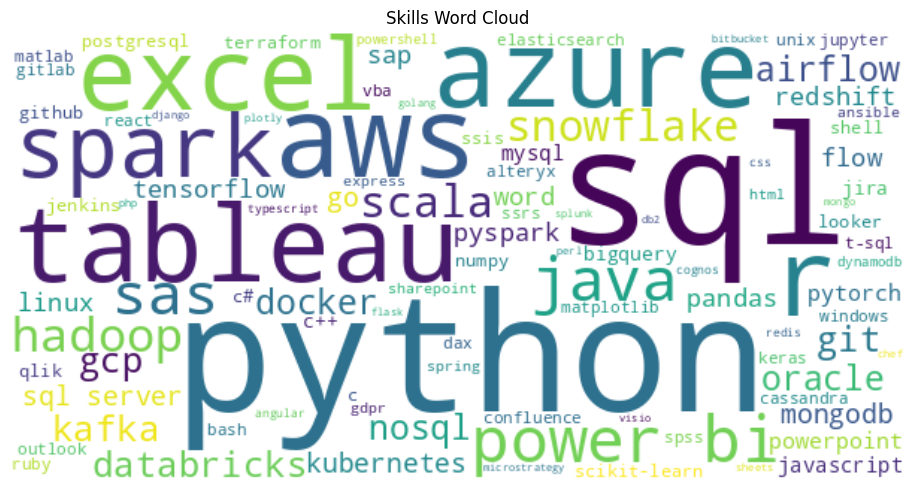

In [23]:
word_freq = pivot_table_sorted['total'].to_dict()

wordcloud = WordCloud(width=600, height=300, background_color='white', 
                     max_words=100, colormap='viridis', 
                     prefer_horizontal=1).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Skills Word Cloud')
plt.tight_layout()
plt.show()


## Findings & Conclusion  
I was, personally, surprised, how much a degree is in demand for Data Scientists in contrast to all other data professions.  
As well as a relatively low level of remote jobs in general.  
Skills-wise, it is rather expected.  
I would like not to get deeper insights than I got from the data, as it would be really interesting to see what other people think about it.  
The important notice is that the data seems to be US-centered and does not provide real numbers for most of the countries, likely.

## Evaluation  
### Set up
The target question for this evaluation is actually what insights people can draw from them. The second one is which forms of visualization of similar data they prefer.  
I asked 3 people to take a look at the visualizations: STEM professional, Junior Data Analyst, and Senior Data Engineer.  
Measures are insight depth and usability, to see which visualizations are preferable.  
As a study format, I chose a journaling study, so I asked those people to write down the insights they found, questions that arose, and what they liked/did not like about each visualization. Then I send the notebook around.   
The ultimate criterion for me in this case is if actually a person can get new insight from the data.  

### Results  
Aggregated results are provided.  
The TRUE/FALSE notation for boolean parameters was rather confusing, as was the name "no degree mentioned."  
The scattered graph seemed too complex and complicated. It did not provide any useful insights, and people did not like to interact with it.  
Between a table with colors and a stacked normalized graph for percentage of remote jobs and degree requirement preferences separated.  
The fact that one can drag the mouse to the graph for interaction is not intuitive.  

As for the insights that people got, the most important one was from the Junior Data Analyst - she said that it seems that she has the chance to get a job offer without the degree and needs to refresh python.  

Other insights are listed below:  

The number of vacancies with remote work according to the data is quite low - less than 10% (although this is already the time after the COVID)  
While no degree mention - 29% (it was not clear if this means that degree is not required or not specified?)  
Almost half of the data engineer vacancies do NOT require a degree, while only 5% of such vacancies are for data scientists and ML engineers  
The level of remote work varies from a minimum of 1% for Singapore and 15% in Sudan (People actually wonder why so)    
A degree is most often not required in the UK, and in the USA this figure is the lowest  
The highest number of vacancies is in the USA, in second place is India. Among individual countries, the least is in Saudi Arabia. But here you probably also need to look at the percentage of the population/area, etc.  
It turns out that in the Russian Federation, Brazil and Romania the highest number of remote work (up to 25%) and the degree is not required. And in Asia, there is little remote work (Singapore, Hong Kong, Malaysia), but a degree in these countries is also not required in a quarter of vacancies  
By skills: most often required sql, python (10% of vacancies), visualization tools and excel are found in 5% of vacancies  
Skills by job title. Of the expected for a data analyst, business analyst, scientist (and total) sql is in the top along with python. spark, aws, azure (STEM and Junior Data Analysts were wondering what are those serveces) are in the top 10 necessary skills  

### P.S.  
I hope this analysis was interesting for you, and if you get any new insights - I will be happy to hear about them!